# Amazon food review dataset apply truncated SVD

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews


# Objective
1. Take 2000 words by TFIDF importance 
2. Calculate cooccurance matrix with neighbourhood of size 5 and count how many times wi occur in context of wj
3. Then do truncated SVD
4. try multiple value of k(find optimal k by amount of variance explained)[use singular value]
5. cluster(kmeans k=50 ) word vector for top 2000
6. word cluster together should be related

# Import data and libraries
 

In [1]:
from sklearn.manifold import TSNE
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression

con = sqlite3.connect('database.sqlite') 

#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

C:\Users\suman\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\suman\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Data preprocessing

In [2]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

filtered_data.sample(5)
filtered_data['Score'].value_counts()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [186]:
#take only 50000 data
print('total data \n',sorted_data['Score'].value_counts())
#clean_data=sorted_data.sample(frac=1).groupby('Score').head(10000)
#take stratified sampling i.e. positive and negative reviews are proportionate to raw data
#testing
_ , clean_data = train_test_split(sorted_data, test_size = 50000, random_state=1,stratify = sorted_data['Score'] )
clean_data['Score'].value_counts()

total data 
 positive    307063
negative     57110
Name: Score, dtype: int64


positive    42159
negative     7841
Name: Score, dtype: int64

In [187]:
# Clean html tag and punctuation
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r' ',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(sno.stem('tasty'))

i=0
str1=' '
mystop={'of','four','one','would'}
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if((cleaned_words.lower() not in stop) & (cleaned_words.lower() not in mystop)):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1
    
clean_data['CleanedText']=final_string
print(clean_data.shape)
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
#clean_data
clean_data['CleanedText'].sample(2)
clean_data['CleanedText'].iloc[0]

tasti
(50000, 11)


C:\Users\suman\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


b'use lot coconut late granola cake cup cake etc particular brand serv purpos well price good'

# Get top 2000 words by TFIDF score and create co-occurence matrix by window 5

In [188]:
x=clean_data['CleanedText'].values
y = clean_data['Score']
#ignore terms that appears in less than 20 document
tf_idf_vect = TfidfVectorizer(min_df = 20)
final_counts = tf_idf_vect.fit_transform(x)
#use the same vectors to convert test data
indices = np.argsort(tf_idf_vect.idf_)[::-1]
features = tf_idf_vect.get_feature_names()
#testing
top_n = 2000
top_features = [features[i] for i in indices[:top_n]]
print (top_features[0:20])
print('len of top feature',len(top_features))

#remove other words from review
final_string=[]
all_string=[]

i=0
for sent in clean_data['CleanedText'].values:
    
    filtered_sentence=[]
    for w in sent.decode('utf8').split():
                if(w in top_features):
                    filtered_sentence.append(w.encode('utf8'))
                    
                else:
                    continue                   
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    if ((i<5) & (str1!=b'')):
        print('sentence copy',str1)
    if (str1.decode('utf8') !=''):
      i=i+1  
      final_string.append(str1)
      all_string.append(str1)
    
#clean_data['CleanedText']=final_string
#Now final_string is ready to work with
#print(clean_data['CleanedText'].shape)
all_string[0:20]


['frapp', 'brave', 'cornstarch', 'unsatisfi', 'bourbon', 'omaha', 'lundberg', 'wider', 'crude', 'slot', 'understood', 'blog', 'understat', 'blade', 'strengthen', 'carolina', 'incid', 'udon', 'densiti', 'hound']
len of top feature 2000
sentence copy b'neighborhood mighti'
sentence copy b'meanwhil economi drag govern cell cell cell govern vote'
sentence copy b'holi yield mist yield math mist yield mist arizona mediocr elig mist'
sentence copy b'cornstarch lump agent'
sentence copy b'crowd'


[b'neighborhood mighti',
 b'meanwhil economi drag govern cell cell cell govern vote',
 b'holi yield mist yield math mist yield mist arizona mediocr elig mist',
 b'cornstarch lump agent',
 b'crowd',
 b'cheat chlorid',
 b'lap cornstarch merrick',
 b'bank til rees',
 b'electrolyt gatorad unnatur',
 b'kuerig',
 b'largest carmel saturday',
 b'queen',
 b'aluminum aluminum ugh',
 b'smack',
 b'model morsel',
 b'nugget',
 b'lite',
 b'newton',
 b'magazin',
 b'quench thirst']

In [189]:
#Convert to cooccurance mat
#type(final_string)
print(len(top_features))
window=5
len1=len(top_features)
#print(len)
m=np.zeros([len1,len1])
columns=top_features
rows=top_features
df=pd.DataFrame(m,columns=columns,index=rows)
#print(df)

def cal_occ(sentence,df):
    sen=sentence.split()
    l=len(sen)-1
    for i,word in enumerate(sen):
        #loop through every sentence in a window and get neigherest words and keep adding
        for j in range(max(i-window,0),min(i+window+1,l+1)):
            if word!=sen[j]:
                #print('printing',word,sen[j])
                df[word][sen[j]]+=1
                
for sentence in final_string:
    #print('call',sentence)
    cal_occ(sentence.decode('utf8'),df)
    
print(df.shape)    

2000
(2000, 2000)


In [190]:
from sklearn.preprocessing import StandardScaler
#Get cooccuring words for a given word
print('The most cooccuring word with ',df.index[4])
aa=df.iloc[4]
bb=aa.sort_values(ascending=False)
print(type(bb))

The most cooccuring word with  bourbon
<class 'pandas.core.series.Series'>


In [191]:
#df

# Create countvectorizer using cooccurence matrix

In [192]:
#count_vect = CountVectorizer(vocabulary=top_features) #in scikit-learn
#X = count_vect.fit_transform(final_string)

#print(X.shape)
          
#Cooccurance matrix    
#X = (X.T * X) # this is co-occurrence matrix in sparse csr format
#X.setdiag(0) # sometimes you want to fill same word cooccurence to 0
#print(X.todense()) 

#print(count_vect.vocabulary_)                             
                   
#Create truncated SVD
from sklearn.decomposition import TruncatedSVD

#Try different component
l=[50,100,200,250,300,400,500,800,1000]
for i in l:
  svd = TruncatedSVD(n_components=i, n_iter=7, random_state=0)
  svd.fit(df.values)
  #print(svd.explained_variance_ratio_)  
  l1=svd.explained_variance_ratio_
  print('% variance explained with component ',i,svd.explained_variance_ratio_.sum()) 
  #print('singular values',svd.singular_values_)

#So looks like with 1000 component 96% variance is explained


% variance explained with component  50 0.36579687381
% variance explained with component  100 0.493899032028
% variance explained with component  200 0.640628352312
% variance explained with component  250 0.690038705112
% variance explained with component  300 0.730234281914
% variance explained with component  400 0.793356505632
% variance explained with component  500 0.841036750945
% variance explained with component  800 0.930341375921
% variance explained with component  1000 0.962662429164


SO by 500 component 84% variance is explained
# Use SVD

In [205]:
#VT = svd.components_
#TruncatedSVD is basically a wrapper around sklearn.utils.extmath.randomized_svd; you can manually call this yourself like this:

from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(df.values, 
                              n_components=500,
                              n_iter=50,
                              random_state=0)

print('U value\n')
#print(U)
print('sigma value\n')
#print(Sigma)
print('VT value\n')
#print(VT)
print(U.shape,Sigma.shape,VT.shape)
#print('1st word vector representation',df.index[0])

#take log transform
#U=np.log(U+1)


U value

sigma value

VT value

(2000, 500) (500,) (500, 2000)


# Form cluster of 10 using those important words SVD value


# Get top few words similar to a random word

In [214]:
from random import randint
j=randint(0, 2000)
print('1st word vector representation',df.index[j],' for j',j)#print(U.shape[0])
#Calculate distance of this word with all words and sort in descending order
l=[]
for i in range(U.shape[1]):
  a=np.linalg.norm(U[j]-U[i])
  l.append(a)
l1=sorted(range(len(l)), key=lambda k: l[k])
#print(l)
print('top 10 words similar to ',df.index[j],' are ',df.index[l1[0:10]])

1st word vector representation massag  for j 99
top 10 words similar to  massag  are  Index(['massag', 'kuerig', 'choclat', 'runner', 'incid', 'gosh', 'seldom',
       'crouton', 'these', 'frapp'],
      dtype='object')


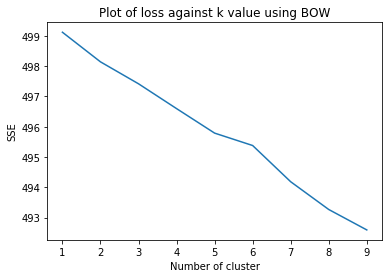

()
in cluster 
 0
[1836]
flip
in cluster 
 1
[  59  342  716 1269 1457 1696 1771]
breastmilk
repel
pediatrici
enfamil
scream
advanc
gerber
in cluster 
 2
[ 56  97 262 346 434 465 476 502 509 554]
bridg
avoderm
chlorin
brandi
dextros
lessen
eukanuba
bypass
saccharin
in cluster 
 3
[430]
egbert
in cluster 
 4
[1812]
genet
in cluster 
 5
[ 877  891 1161 1724]
firmer
helper
barrel
model
in cluster 
 6
[ 112  168  500  673  694  791  950 1000 1409 1417]
knead
laboratori
coca
tim
river
artisan
spelt
horseradis
loav
in cluster 
 7
[1619]
ultra
in cluster 
 8
[1797]
thirst
in cluster 
 9
[  78   80  424  632  835 1644 1691]
ghee
semolina
marmalad
vietnames
garnish
tiger
sweat
in cluster 
 10
[1194]
lobster
in cluster 
 11
[ 1  6  7  8 11 12 13 15 16 17]
brave
lundberg
wider
crude
blog
understat
blade
carolina
incid
in cluster 
 12
[38]
lapsang
in cluster 
 13
[246]
shim
in cluster 
 14
[ 21  66  82  84 145 149 172 185 201 231]
dijon
pari
stat
frizzi
unbleach
ib
candl
mar
asept
in cluster 
 15


In [215]:
from sklearn.cluster import KMeans
# Now U is vec presentation of words
n_clusters=10
kmeans=KMeans(n_clusters=10, random_state=0).fit(U)
kmeans.cluster_centers_

sse = {}
for k in range(1, 10):
    kmeans = KMeans(init='k-means++',n_clusters=k, max_iter=100).fit(U)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.title("Plot of loss against k value using BOW")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#a=np.where(kmeans.labels_ == 1)[0]
#b=np.where(kmeans.labels_ == 0)[0]
#check 5 text for cluster 1

kmeans = KMeans(init='k-means++',n_clusters=50, max_iter=100).fit(U)
n_clusters=50
print(a.shape)
for i in range(n_clusters):
  a=np.where(kmeans.labels_ == i)[0]
  print('in cluster \n',i)
  print(a[0:10]) 
  k=0
  for j in a:
      k=k+1
      if (k<10):  
        print(top_features[j][:10])  


# Observation
To find the similar word its not giving proper words, maybe non engligh words and text cleanning is required much. But most of the cases top similar word is the word itself which proofs its calculating the distance
Even U vector after log transform also not producing better result as below

In [216]:
#try log transform to find similar words
U=np.log(U+1)

In [227]:
j=randint(0, 2000)
print('1st word vector representation',df.index[j],' for j',j)#print(U.shape[0])
#Calculate distance of this word with all words and sort in descending order
#take log transform
l=[]
for i in range(U.shape[1]):
  a=np.linalg.norm(U[j]-U[i])
  l.append(a)
l1=sorted(range(len(l)), key=lambda k: l[k])
#print(l)
print('top 10 words similar to ',df.index[j],' are ',df.index[l1[0:10]])

1st word vector representation confess  for j 352
top 10 words similar to  confess  are  Index(['confess', 'kuerig', 'these', 'yuk', 'gosh', 'colleagu', 'speedi',
       'frapp', 'toasti', 'choclat'],
      dtype='object')


Ignore the above 2 plots those plots are plotted below again